In [ ]:
import os, zipfile, shutil, math
from pathlib import Path
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)




Device: cuda


In [2]:
import urllib.request

ROOT = Path.cwd() / "ecg_project"
ROOT.mkdir(exist_ok=True, parents=True)

# Download the GitHub repo zip (main branch)
repo_zip = ROOT / "physionet_ECG_data-main.zip"
repo_url = "https://github.com/mathworks/physionet_ECG_data/archive/refs/heads/main.zip"

if not repo_zip.exists():
    print("Downloading:", repo_url)
    urllib.request.urlretrieve(repo_url, repo_zip)

# Unzip repo
repo_dir = ROOT / "physionet_ECG_data-main"
if not repo_dir.exists():
    with zipfile.ZipFile(repo_zip, "r") as z:
        z.extractall(ROOT)

# ECGData.zip is inside the extracted repo
ecgdata_zip = repo_dir / "ECGData.zip"
assert ecgdata_zip.exists(), f"Expected {ecgdata_zip} to exist."

# Extract ECGData.mat
ecg_extract_dir = repo_dir / "ECGData_extracted"
ecg_extract_dir.mkdir(exist_ok=True)
with zipfile.ZipFile(ecgdata_zip, "r") as z:
    z.extractall(ecg_extract_dir)

mat_path = ecg_extract_dir / "ECGData.mat"
assert mat_path.exists(), f"Expected {mat_path} to exist."
print("Found:", mat_path)


Downloading: https://github.com/mathworks/physionet_ECG_data/archive/refs/heads/main.zip
Found: c:\codes\pytorchRun\Deep_learning_project\ecg_project\physionet_ECG_data-main\ECGData_extracted\ECGData.mat


In [4]:
import scipy.io

def load_ecg_mat(mat_path: Path):
    """
    Loads ECGData.mat that contains a MATLAB struct ECGData with fields:
    - Data: (162, 65536)
    - Labels: (162,)
    """
    mat = scipy.io.loadmat(mat_path, squeeze_me=True, struct_as_record=False)
    if "ECGData" not in mat:
        raise KeyError(f"ECGData not found in {mat_path}. Keys: {list(mat.keys())}")

    ecg = mat["ECGData"]  # MATLAB struct-like object
    data = np.array(ecg.Data)          # shape (N, 65536)
    labels_raw = np.array(ecg.Labels)  # shape (N,) but type may vary

    # Normalize labels to list[str]
    labels = []
    for x in labels_raw:
        if isinstance(x, bytes):
            labels.append(x.decode("utf-8"))
        else:
            labels.append(str(x))
    return data, labels

data, labels = load_ecg_mat(mat_path)
data = data.astype(np.float32)

print("Data shape:", data.shape)
print("First labels:", labels[:10])
print("Class counts:", {c: labels.count(c) for c in sorted(set(labels))})


Data shape: (162, 65536)
First labels: ['ARR', 'ARR', 'ARR', 'ARR', 'ARR', 'ARR', 'ARR', 'ARR', 'ARR', 'ARR']
Class counts: {'ARR': 96, 'CHF': 30, 'NSR': 36}


In [5]:
def get_jet_colormap(n=128):
    cmap = matplotlib.cm.get_cmap("jet", n)  # quantized jet
    return cmap

JET128 = get_jet_colormap(128)

def scalogram_to_rgb_uint8(S, out_hw=(227, 227), clip_pct=99.5):
    """
    S: 2D nonnegative scalogram (freq/scale x time)
    Returns: uint8 RGB image array (H, W, 3)
    """
    S = np.asarray(S, dtype=np.float32)
    # Robust normalize (helps with outliers)
    hi = np.percentile(S, clip_pct)
    if hi <= 0:
        hi = float(S.max() + 1e-6)
    S = np.clip(S / hi, 0.0, 1.0)

    # Quantize to 0..127 so it matches jet(128) bins
    idx = (S * 127.0).round().astype(np.uint8)

    # Map indices to RGB via colormap
    rgba = (JET128(idx / 127.0) * 255.0).astype(np.uint8)  # (...,4)
    rgb = rgba[..., :3]

    # Resize to CNN input size
    img = Image.fromarray(rgb)
    img = img.resize(out_hw, resample=Image.BILINEAR)
    return np.array(img, dtype=np.uint8)

# --- CWT backends ---
def cwt_magnitude(signal_1d, fs=128.0, n_scales=128):
    """
    Returns |CWT| as 2D array (n_scales, n_samples).

    Preference:
    1) ssqueezepy (if installed)
    2) PyWavelets fallback
    """
    x = np.asarray(signal_1d, dtype=np.float32)

    # Try ssqueezepy
    try:
        from ssqueezepy import cwt, Wavelet
        # Using generalized Morse wavelet family (good match to MATLAB’s default analytic Morse conceptually)
        # nv ~ voices per octave concept; MATLAB example uses 12 voices per octave.
        wavelet = Wavelet()  # default wavelet in ssqueezepy
        # Provide explicit number of scales (uniformly spaced in log scale via ssqueezepy defaults)
        Wx, scales = cwt(x, wavelet=wavelet, nv=12, scales=n_scales)
        S = np.abs(Wx)
        return S
    except Exception as e:
        # Fall back to PyWavelets
        import pywt
        # Complex Morlet is a common analytic wavelet substitute if Morse isn’t available.
        wavelet = "cmor1.5-1.0"
        # Choose scales log-spaced to cover a broad band
        # (Exact matching with MATLAB is not required because we resize to 227x227 anyway.)
        scales = np.geomspace(1, 256, num=n_scales).astype(np.float32)
        coefs, freqs = pywt.cwt(x, scales, wavelet, sampling_period=1/fs)
        S = np.abs(coefs).astype(np.float32)
        return S

# Quick test on one signal
S_test = cwt_magnitude(data[0], fs=128.0, n_scales=128)
img_test = scalogram_to_rgb_uint8(S_test, out_hw=(227, 227))
print("Scalogram shape:", S_test.shape, "RGB shape:", img_test.shape, "dtype:", img_test.dtype)


C:\Users\mdmahha\AppData\Local\Temp\ipykernel_67008\1226359839.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = matplotlib.cm.get_cmap("jet", n)  # quantized jet


Scalogram shape: (128, 65536) RGB shape: (227, 227, 3) dtype: uint8


write images to disk in class folders

In [6]:
IMG_ROOT = ROOT / "data"  # like MATLAB dataDir
if IMG_ROOT.exists():
    print("Image folder already exists:", IMG_ROOT)
else:
    IMG_ROOT.mkdir(parents=True)

# Create class subfolders
classes = sorted(set(labels))
for c in classes:
    (IMG_ROOT / c).mkdir(parents=True, exist_ok=True)

# Generate and save scalograms
for i in tqdm(range(len(labels)), desc="Creating scalogram images"):
    label = labels[i]
    out_path = IMG_ROOT / label / f"{label}_{i+1}.jpg"
    if out_path.exists():
        continue

    sig = data[i]  # shape (65536,)
    S = cwt_magnitude(sig, fs=128.0, n_scales=128)
    rgb = scalogram_to_rgb_uint8(S, out_hw=(227, 227))
    Image.fromarray(rgb).save(out_path, quality=95)

print("Done. Images at:", IMG_ROOT)


Creating scalogram images: 100%|██████████| 162/162 [05:38<00:00,  2.09s/it]

Done. Images at: c:\codes\pytorchRun\Deep_learning_project\ecg_project\data


Train/validation split (80/20) + DataLoaders

In [7]:
from torch.utils.data import random_split

# ImageNet normalization (pretrained SqueezeNet expects this)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD  = (0.229, 0.224, 0.225)

tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

full_ds = datasets.ImageFolder(str(IMG_ROOT), transform=tfm)
class_names = full_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

# 80/20 split
n = len(full_ds)
n_train = int(0.8 * n)
n_val = n - n_train
train_ds, val_ds = random_split(full_ds, [n_train, n_val], generator=torch.Generator().manual_seed(0))

batch_size = 15
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Train/Val sizes:", len(train_ds), len(val_ds))


Classes: ['ARR', 'CHF', 'NSR']
Train/Val sizes: 129 33


Fine-tune SqueezeNet (like MATLAB layer replacement)

In [8]:
def build_squeezenet(num_classes: int):
    # Newer torchvision API
    try:
        weights = models.SqueezeNet1_1_Weights.DEFAULT
        model = models.squeezenet1_1(weights=weights)
    except Exception:
        model = models.squeezenet1_1(pretrained=True)

    # Replace final conv layer to output num_classes (MATLAB replaced conv10 to 3 filters)
    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=1)
    model.num_classes = num_classes
    return model

model = build_squeezenet(num_classes).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
epochs = 20

def run_epoch(model, loader, train: bool):
    model.train(train)
    total_loss, total_correct, total = 0.0, 0, 0

    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        logits = model(x)
        loss = criterion(logits, y)

        if train:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)

    return total_loss / total, total_correct / total

best_val = 0.0
SAVE_DIR = ROOT / "results"
SAVE_DIR.mkdir(exist_ok=True)
best_path = SAVE_DIR / "ecg_squeezenet_best.pt"

for ep in range(1, epochs + 1):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    va_loss, va_acc = run_epoch(model, val_loader, train=False)

    print(f"Epoch {ep:02d}/{epochs} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

    if va_acc > best_val:
        best_val = va_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names,
        }, best_path)

print("Best val accuracy:", best_val, "saved to", best_path)


Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\mdmahha/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 5.54MB/s]


Epoch 01/20 | train loss 1.1301 acc 0.4109 | val loss 0.9926 acc 0.6061
Epoch 02/20 | train loss 1.0128 acc 0.5891 | val loss 0.9475 acc 0.6061
Epoch 03/20 | train loss 0.9644 acc 0.5891 | val loss 0.9317 acc 0.6061
Epoch 04/20 | train loss 0.9137 acc 0.5891 | val loss 0.9144 acc 0.6061
Epoch 05/20 | train loss 0.8948 acc 0.5891 | val loss 0.8939 acc 0.6061
Epoch 06/20 | train loss 0.8571 acc 0.5969 | val loss 0.8704 acc 0.6061
Epoch 07/20 | train loss 0.8204 acc 0.6124 | val loss 0.8382 acc 0.6364
Epoch 08/20 | train loss 0.7694 acc 0.6589 | val loss 0.7933 acc 0.6364
Epoch 09/20 | train loss 0.7380 acc 0.6822 | val loss 0.7366 acc 0.6970
Epoch 10/20 | train loss 0.6738 acc 0.7054 | val loss 0.6701 acc 0.7273
Epoch 11/20 | train loss 0.5810 acc 0.7907 | val loss 0.6063 acc 0.7273
Epoch 12/20 | train loss 0.5539 acc 0.8140 | val loss 0.6566 acc 0.7273
Epoch 13/20 | train loss 0.5368 acc 0.8062 | val loss 0.5810 acc 0.7576
Epoch 14/20 | train loss 0.4907 acc 0.7752 | val loss 0.5600 acc

Evaluate: accuracy + confusion matrix + precision/recall

In [9]:
ckpt = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(ckpt["model_state"])
model.eval()

all_preds, all_true = [], []
with torch.no_grad():
    for x, y in val_loader:
        x = x.to(DEVICE)
        logits = model(x)
        preds = logits.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds.tolist())
        all_true.extend(y.numpy().tolist())

acc = accuracy_score(all_true, all_preds)
cm = confusion_matrix(all_true, all_preds)
print("Validation accuracy:", acc)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n")
print(classification_report(all_true, all_preds, target_names=class_names))


C:\Users\mdmahha\AppData\Local\Temp\ipykernel_67008\2932724525.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(best_path, map_location=DEVICE)


Validation accuracy: 0.8181818181818182
Confusion matrix:
 [[17  0  3]
 [ 2  4  0]
 [ 0  1  6]]

Classification report:

              precision    recall  f1-score   support

         ARR       0.89      0.85      0.87        20
         CHF       0.80      0.67      0.73         6
         NSR       0.67      0.86      0.75         7

    accuracy                           0.82        33
   macro avg       0.79      0.79      0.78        33
weighted avg       0.83      0.82      0.82        33



Inference on a raw ECG signal (1×65536 → probabilities)

In [10]:
@torch.no_grad()
def predict_ecg_signal(signal_1x65536, model, class_names, fs=128.0):
    """
    signal_1x65536: array-like shape (65536,) or (1,65536)
    Returns dict {class_name: prob}
    """
    x = np.asarray(signal_1x65536, dtype=np.float32).reshape(-1)
    assert x.shape[0] == 65536, f"Expected length 65536, got {x.shape[0]}"

    S = cwt_magnitude(x, fs=fs, n_scales=128)
    rgb = scalogram_to_rgb_uint8(S, out_hw=(227, 227))

    # Apply same transforms as training
    tens = tfm(Image.fromarray(rgb)).unsqueeze(0).to(DEVICE)  # (1,3,227,227)

    model.eval()
    logits = model(tens)
    probs = torch.softmax(logits, dim=1).squeeze(0).cpu().numpy()

    return {class_names[i]: float(probs[i]) for i in range(len(class_names))}

# Example: predict on one of the original signals
probs = predict_ecg_signal(data[0], model, class_names, fs=128.0)
probs


{'ARR': 0.8042250871658325,
 'CHF': 0.05559980496764183,
 'NSR': 0.14017514884471893}

In [11]:
example = torch.randn(1, 3, 227, 227, device=DEVICE)
scripted = torch.jit.trace(model, example)
ts_path = SAVE_DIR / "ecg_squeezenet_ts.pt"
scripted.save(str(ts_path))
print("Saved TorchScript:", ts_path)


Saved TorchScript: c:\codes\pytorchRun\Deep_learning_project\ecg_project\results\ecg_squeezenet_ts.pt


In [12]:
from torch.utils.data import random_split, DataLoader

# full_ds = datasets.ImageFolder(str(IMG_ROOT), transform=tfm)  # already created earlier
n = len(full_ds)

n_train = int(0.8 * n)
n_val   = int(0.1 * n)
n_test  = n - n_train - n_val

train_ds, val_ds, test_ds = random_split(
    full_ds, [n_train, n_val, n_test],
    generator=torch.Generator().manual_seed(0)
)

batch_size = 15
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print("Split sizes:", len(train_ds), len(val_ds), len(test_ds))


Split sizes: 129 16 17


In [13]:
import torch
import numpy as np

def accuracy_from_logits(logits, y):
    preds = logits.argmax(dim=1)
    return (preds == y).float().mean().item()

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = model(x)
        loss = criterion(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += bs

    return total_loss / total, total_correct / total


In [16]:
import torch.nn as nn

# model = build_squeezenet(num_classes).to(DEVICE)  # already created earlier
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)

use_amp = (DEVICE == "cuda")
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

history = {
    "train_loss": [], "train_acc": [],
    "val_loss":   [], "val_acc":   [],
    "test_loss":  [], "test_acc":  []
}

best_val_acc = -1.0
best_path = SAVE_DIR / "ecg_squeezenet_best.pt"

epochs = 40

for ep in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for x, y in train_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=use_amp):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        bs = x.size(0)
        running_loss += loss.item() * bs
        running_correct += (logits.argmax(dim=1) == y).sum().item()
        running_total += bs

    train_loss = running_loss / running_total
    train_acc  = running_correct / running_total

    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["test_loss"].append(test_loss)
    history["test_acc"].append(test_acc)

    print(f"Epoch {ep:02d}/{epochs} | "
          f"train: loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val: loss {val_loss:.4f} acc {val_acc:.4f} | "
          f"test: loss {test_loss:.4f} acc {test_acc:.4f}")

    # Save best by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "model_state": model.state_dict(),
            "class_names": class_names,
            "history": history,
            "best_val_acc": best_val_acc
        }, best_path)

print("Best val acc:", best_val_acc, "saved to:", best_path)


C:\Users\mdmahha\AppData\Local\Temp\ipykernel_67008\3449082549.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
C:\Users\mdmahha\AppData\Local\Temp\ipykernel_67008\3449082549.py:33: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp):


Epoch 01/40 | train: loss 0.0579 acc 0.9922 | val: loss 0.6284 acc 0.6875 | test: loss 0.4710 acc 0.7647
Epoch 02/40 | train: loss 0.0688 acc 0.9922 | val: loss 0.6009 acc 0.7500 | test: loss 0.4236 acc 0.8235
Epoch 03/40 | train: loss 0.0607 acc 0.9922 | val: loss 0.5383 acc 0.8125 | test: loss 0.4173 acc 0.8235
Epoch 04/40 | train: loss 0.0329 acc 1.0000 | val: loss 0.6247 acc 0.7500 | test: loss 0.7028 acc 0.7647
Epoch 05/40 | train: loss 0.0250 acc 1.0000 | val: loss 0.5982 acc 0.8125 | test: loss 0.4759 acc 0.8235
Epoch 06/40 | train: loss 0.0538 acc 0.9845 | val: loss 1.0856 acc 0.7500 | test: loss 1.1636 acc 0.7647
Epoch 07/40 | train: loss 0.1019 acc 0.9690 | val: loss 0.5388 acc 0.8125 | test: loss 1.0996 acc 0.7647
Epoch 08/40 | train: loss 0.0655 acc 0.9922 | val: loss 1.0391 acc 0.7500 | test: loss 0.5615 acc 0.7647
Epoch 09/40 | train: loss 0.0725 acc 0.9767 | val: loss 0.3854 acc 0.7500 | test: loss 0.7074 acc 0.7647
Epoch 10/40 | train: loss 0.0399 acc 1.0000 | val: loss

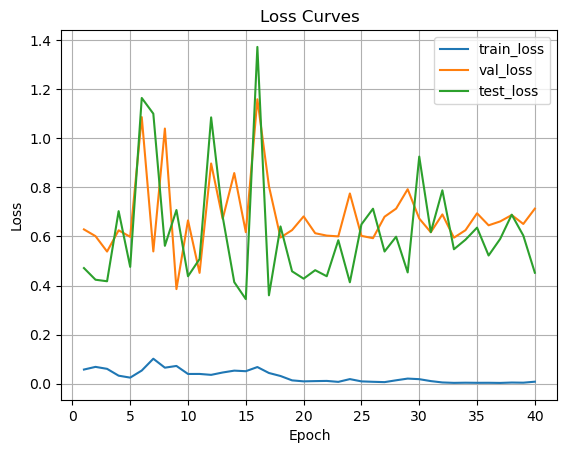

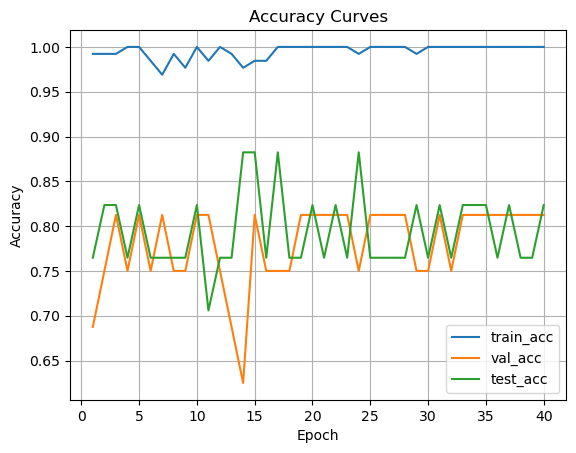

In [17]:
import matplotlib.pyplot as plt

epochs_axis = np.arange(1, len(history["train_loss"]) + 1)

plt.figure()
plt.plot(epochs_axis, history["train_loss"], label="train_loss")
plt.plot(epochs_axis, history["val_loss"],   label="val_loss")
plt.plot(epochs_axis, history["test_loss"],  label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs_axis, history["train_acc"], label="train_acc")
plt.plot(epochs_axis, history["val_acc"],   label="val_acc")
plt.plot(epochs_axis, history["test_acc"],  label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()
plt.grid(True)
plt.show()
